# Predictive Model for Synthetic Patient Education Data

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
file = 'synthetic_patient_education_merged.csv'
data = pd.read_csv(file)

In [4]:
data.head(1)

,result_id,patient_id,module_number,pre_score,post_score,feedback,feedback_score,completed,delta,age,sex,va_l,va_r,disease,va_l_group,va_r_group,best_va,sentiment
0,1,3469,1,4.0,4.0,Would recommend to others,1.0,1,0.0,76.0,M,lp,20/250,wet,Very_Poor,Very_Poor,Very_Poor,0.0


In [5]:
data.shape

(100, 18)

In [8]:
#check missing values
data.isnull().sum().to_frame().T

,result_id,patient_id,module_number,pre_score,post_score,feedback,feedback_score,completed,delta,age,sex,va_l,va_r,disease,va_l_group,va_r_group,best_va,sentiment
0,0,0,0,0,0,0,0,0,0,49,49,49,49,49,0,0,0,0


In [11]:
#Since there are such a high percentage of demographics missing from our data,
#we will create a model that only uses pre_score, sentiment, and best_va to predict post_score

In [14]:
num_feats = ['pre_score','sentiment']
cat_feat = ['best_va']

features = num_feats + cat_feat

In [39]:
X = data[features]
y = data.loc[:,'post_score']

In [40]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state =10)

## Preprocessing

In [41]:
num_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler',StandardScaler())
    ]
)

cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Missing')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_feats),
        ('cat', cat_transformer, cat_feat)
    ]
)

In [42]:
classifier = Pipeline(steps = [
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators = 300, class_weight = 'balanced', random_state = 10))
     ])

classifier.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [43]:
y_pred = classifier.predict(X_test)

In [44]:
proba = classifier.predict_proba(X_test)[:,1]

In [45]:
print(proba)

[0.00566424 0.05831859 0.00303797 0.03666667 0.         0.04209406
 0.255724   0.01       0.         0.78165897 0.         0.03197667
 0.0244318  0.31978147 0.25614267 0.         0.00666667 0.00293785
 0.0483542  0.00303797 0.255724   0.55624733 0.03794952 0.01185736
 0.14723458 0.46361516 0.07       0.00666667 0.04034983 0.0483542 ]


## Create a Confusion Matrix

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

In [54]:
labels = y_train.unique()

In [55]:
print(labels)

[4. 3. 2. 1.]


In [56]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  1  0  0]
 [ 0  1  3  1]
 [ 0  1  5  3]
 [ 0  0  5 10]]


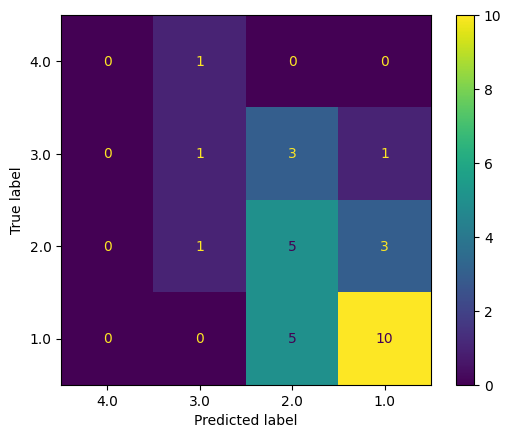

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot()
plt.show()

## Create Classification Report

In [58]:
from sklearn.metrics import classification_report

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.33      0.20      0.25         5
         3.0       0.38      0.56      0.45         9
         4.0       0.71      0.67      0.69        15

    accuracy                           0.53        30
   macro avg       0.36      0.36      0.35        30
weighted avg       0.53      0.53      0.52        30



Overall the model performed not great. This is synthetic data and I will create a model that suits the actual data for the project, but all in all not a great model for not great data provided (Junk in Junk out!)